## A Case Study to Learn Polynomial Chaos Expansion with Kinetic Models

Source of kinetic model:

### Reaction pathways in the electrochemical reduction of nitrate on tin

Electrochimica Acta Journal
[https://doi.org/10.1016/j.electacta.2012.03.154](https://doi.org/10.1016/j.electacta.2012.03.154)


#### Description

This file implements Polynomial Chaos Expansion (PCE) as a learning tool for UQ.

The kinetic model serves a dual purpose: it acts both as a data generator and as a benchmark reference.

<p align="center">
  <img src="mechanism.jpg" alt="Mechanism" width="500"/>
</p>

\begin{align*}
\frac{d[NO_3^-]}{dt} &= -k_1 [NO_3^-] \\
\frac{d[NO_2^-]}{dt} &= +k_1 [NO_3^-] - (k_2 + k_4 + k_5)[NO_2^-] \\
\frac{d[X]}{dt} &= +k_2 [NO_2^-] - k_3 [X] \\
\frac{d[N_2]}{dt} &= +k_3 [X] \\
\frac{d[N_2O]}{dt} &= +k_5 [NO_2^-] \\
\frac{d[NH_3]}{dt} &= +k_4 [NO_2^-]
\end{align*}


### Values obtained in the paper

values obtained using MCMC.

| Rate constant | 95% credible interval (min^-1) |
|---------------|--------------------------------|
| k1            | 0.0216±0.0014                  |
| k2            | 0.0292±0.0036                  |
| k3            | 0.0219±0.0044                  |
| k4            | 0.0021±0.0008                  |
| k5            | 0.0048±0.0008                  |


First, we want to know predict $[NO_3^{-}]$, $[NH_3]$, $[N_2O]$, and $[N_2]$ based on $[NO_3^{-}]_0$ and $t$.

$$ f: R^2 \longrightarrow R^4 $$

Two benchmark will be used: Monte Carlo and Chaospy implementation.

### Nominal case

In [69]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

In [70]:
# Define the system of ODEs
def system_of_odes(t, y, k1, k2, k3, k4, k5):
    NO3, NO2, X, N2, N2O, NH3 = y
    dNO3dt = -k1 * NO3
    dNO2dt = k1 * NO3 - (k2 + k4 + k5) * NO2
    dXdt = k2 * NO2 - k3 * X
    dN2dt = k3 * X
    dN2Odt = k5 * NO2
    dNH3dt = k4 * NO2
    return [dNO3dt, dNO2dt, dXdt, dN2dt, dN2Odt, dNH3dt]

In [71]:
k1 = 0.0216
k2 = 0.0292
k3 = 0.0219
k4 = 0.0021
k5 = 0.0048

NO3init = 10

# Initial conditions
initial_conditions = [NO3init, 0.0, 0.0, 0.0, 0.0, 0.0]  # Initial concentrations

# Time span for the simulation
t_span = (0, 500)  # From 0 to 50 time units

# Solve the ODE system
result = solve_ivp(system_of_odes, t_span, initial_conditions, args=(k1, k2, k3, k4, k5), dense_output=True)

# Time points at which solution is computed
t = np.linspace(t_span[0], t_span[1], 300)

# Get the solution at these time points
solution = result.sol(t)

solution

array([[1.00000000e+01, 9.64524154e+00, 9.30306846e+00, ...,
        2.21211863e-04, 2.13379606e-04, 2.05815460e-04],
       [0.00000000e+00, 3.44200588e-01, 6.56025998e-01, ...,
        3.29151821e-04, 3.17505477e-04, 3.06257985e-04],
       [0.00000000e+00, 8.43542442e-03, 3.22808125e-02, ...,
        3.83050676e-03, 3.70833252e-03, 3.58995811e-03],
       [0.00000000e+00, 1.04460312e-04, 8.06215329e-04, ...,
        8.08436698e+00, 8.08450491e+00, 8.08463850e+00],
       [0.00000000e+00, 1.40381667e-03, 5.43896347e-03, ...,
        1.32956671e+00, 1.32956930e+00, 1.32957180e+00],
       [0.00000000e+00, 6.14169792e-04, 2.37954652e-03, ...,
        5.81685436e-01, 5.81686569e-01, 5.81687663e-01]])

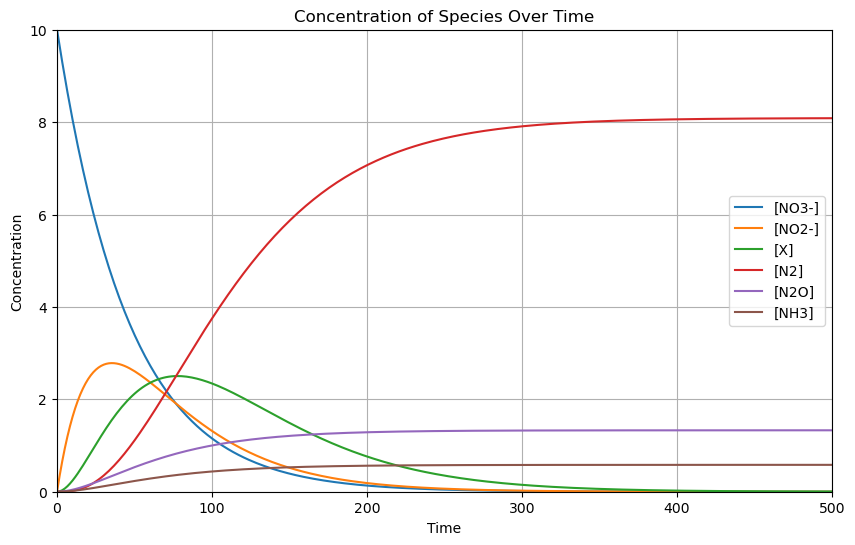

In [72]:
NO3_conc = solution[0]
NO2_conc = solution[1]
X_conc = solution[2]
N2_conc = solution[3]
N2O_conc = solution[4]
NH3_conc = solution[5]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, NO3_conc, label='[NO3-]')
plt.plot(t, NO2_conc, label='[NO2-]')
plt.plot(t, X_conc, label='[X]')
plt.plot(t, N2_conc, label='[N2]')
plt.plot(t, N2O_conc, label='[N2O]')
plt.plot(t, NH3_conc, label='[NH3]')

plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Concentration of Species Over Time')
plt.legend()
plt.grid(True)
plt.xlim(0, t_span[-1])
plt.ylim(0, NO3init)
plt.show()


### Monte Carlo

In [73]:
def simulator(pars, tf, y0, f):
    """
    pars: kinetic model parameters(ks), list
    tf: overall time for reaction, scalar
    y0: initial conditions, list
    f: ode function
    return: concentration of species, list; solve_ivp result
    """
    result = solve_ivp(f, [0, tf], y0, args=pars, dense_output=True)
    conc = result.sol(-1)
    return conc, result.sol

In [74]:
 simulator([0.0216, 0.0292, 0.0219, 0.0021, 0.0048], 500, [NO3init, 0.0, 0.0, 0.0, 0.0, 0.0], system_of_odes)

(array([ 1.02183497e+01, -2.22324303e-01,  3.23840352e-03, -2.34793335e-05,
         5.28480687e-04,  2.31210301e-04]),
 <scipy.integrate._ivp.common.OdeSolution at 0x1411c3310>)

### Now use Monte Carlo simulation to find the output distribution

In [75]:
import time

start_time = time.time()

num_samples = int(1e5)  # number of Monte Carlo samples

# Sample rate constants from normal distributions based on credible intervals
k1_samples = np.random.lognormal(0.0216, 0.0014/2, num_samples)
k2_samples = np.random.lognormal(0.0292, 0.0036/2, num_samples)
k3_samples = np.random.lognormal(0.0219, 0.0044/2, num_samples)
k4_samples = np.random.lognormal(0.0021, 0.0008/2, num_samples)
k5_samples = np.random.lognormal(0.0048, 0.0008/2, num_samples)

# Collect final concentrations for each sample
final_concentrations = []

for i in range(num_samples):
    pars = (k1_samples[i], k2_samples[i], k3_samples[i], k4_samples[i], k5_samples[i])
    conc, _ = simulator(pars, 300, [NO3init, 0.0, 0.0, 0.0, 0.0, 0.0], system_of_odes)
    final_concentrations.append(conc)

final_concentrations = np.array(final_concentrations)

end_time = time.time()
print(f"The Monte Carlo simulation had {num_samples} trials and took {(end_time-start_time)/60:.2f} minutes.")

# Example output: the final concentrations of each species for each Monte Carlo sample
final_concentrations

The Monte Carlo simulation had 100000 trials and took 78.03 minutes.


array([[ 27.67801678, -71.58970793,  22.39935557,  -4.08474086,
         17.82111875,  17.77001191],
       [ 27.66764378, -71.32677699,  22.20013479,  -4.04250818,
         17.77317936,  17.73659474],
       [ 27.66217985, -71.49085487,  22.35090646,  -4.0674348 ,
         17.78304693,  17.75027848],
       ...,
       [ 27.66098619, -71.35319196,  22.22128101,  -4.04489251,
         17.7844284 ,  17.7332314 ],
       [ 27.68286672, -71.50114501,  22.33172427,  -4.08070217,
         17.8058895 ,  17.75943944],
       [ 27.70996205, -71.64232759,  22.39376513,  -4.09237716,
         17.83480337,  17.78660702]])

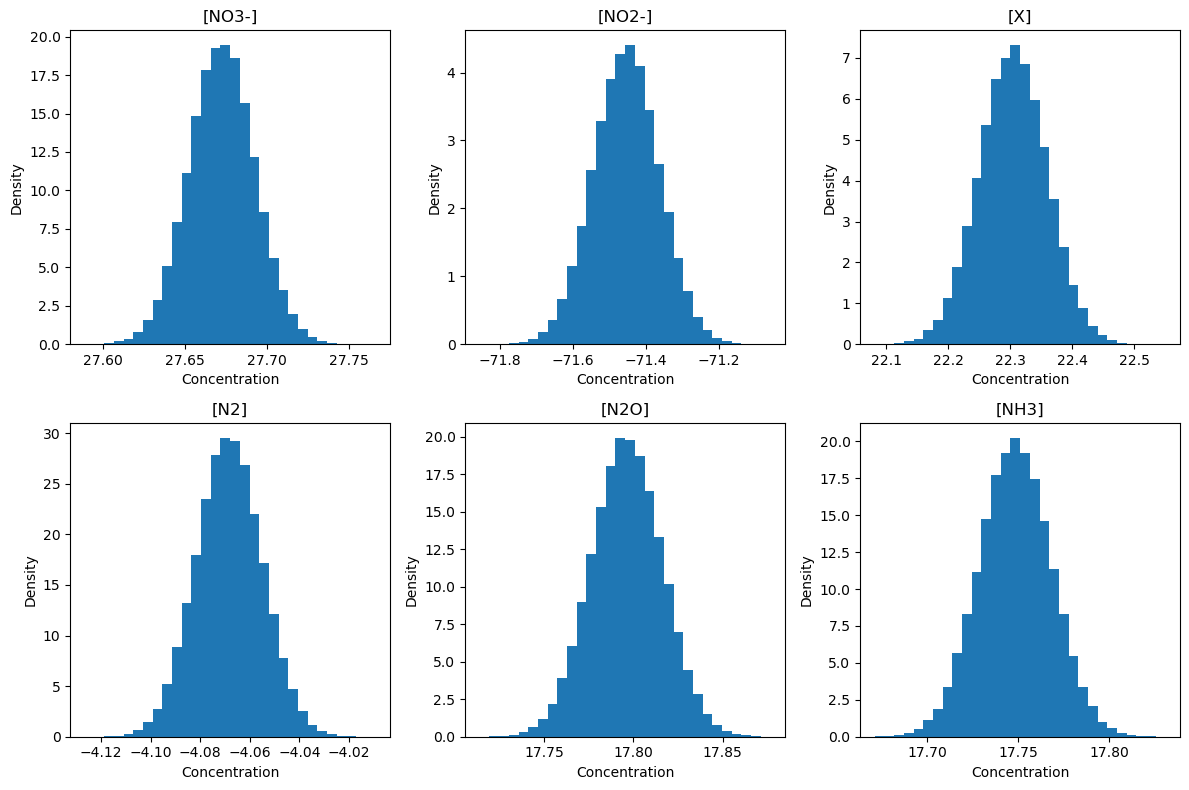

{'[NO3-]': {'Mean': 27.672306929734575,
  'Median': 27.672282300600024,
  'Standard Deviation': 0.02006818798627836},
 '[NO2-]': {'Mean': -71.45303864331312,
  'Median': -71.45267720403477,
  'Standard Deviation': 0.09023229973402223},
 '[X]': {'Mean': 22.304261185563394,
  'Median': 22.3043402307638,
  'Standard Deviation': 0.05439390697623812},
 '[N2]': {'Mean': -4.06834185113162,
  'Median': -4.068374543342706,
  'Standard Deviation': 0.01327460325424398},
 '[N2O]': {'Mean': 17.796402200986297,
  'Median': 17.796364469044526,
  'Standard Deviation': 0.019808775182970608},
 '[NH3]': {'Mean': 17.74839831368235,
  'Median': 17.748381749150226,
  'Standard Deviation': 0.019720047777270357}}

In [76]:
# Plotting the final concentrations of each species
species_names = ['[NO3-]', '[NO2-]', '[X]', '[N2]', '[N2O]', '[NH3]']

plt.figure(figsize=(12, 8))
for i in range(len(species_names)):
    plt.subplot(2, 3, i+1)
    plt.hist(final_concentrations[:, i], bins=30, density=True)
    plt.title(species_names[i])
    plt.xlabel('Concentration')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Calculate and print statistical properties
stat_properties = {}
for i, name in enumerate(species_names):
    mean = np.mean(final_concentrations[:, i])
    median = np.median(final_concentrations[:, i])
    std_dev = np.std(final_concentrations[:, i])
    stat_properties[name] = {'Mean': mean, 'Median': median, 'Standard Deviation': std_dev}

stat_properties

### Statistical test can be applied to see if the simulation results belong to some distribution



In [77]:
import scipy.stats as stats

# Statistical tests for normal distribution
stat_test_results = {}

for i, name in enumerate(species_names):
    data = final_concentrations[:, i]
    shapiro_test = stats.shapiro(data)
    ks_test = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
    stat_test_results[name] = {'Shapiro-Wilk Test': shapiro_test, 'Kolmogorov-Smirnov Test': ks_test}

stat_test_results


/Users/yuliuzhifei/anaconda3/envs/UQ/lib/python3.9/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


{'[NO3-]': {'Shapiro-Wilk Test': ShapiroResult(statistic=0.9999780654907227, pvalue=0.8689876794815063),
  'Kolmogorov-Smirnov Test': KstestResult(statistic=0.0021680719470120735, pvalue=0.7341826559206169, statistic_location=27.679079840831474, statistic_sign=-1)},
 '[NO2-]': {'Shapiro-Wilk Test': ShapiroResult(statistic=0.9999716877937317, pvalue=0.6572701334953308),
  'Kolmogorov-Smirnov Test': KstestResult(statistic=0.0019404308466027809, pvalue=0.84501856620906, statistic_location=-71.44993928649765, statistic_sign=-1)},
 '[X]': {'Shapiro-Wilk Test': ShapiroResult(statistic=0.9999831318855286, pvalue=0.9687088131904602),
  'Kolmogorov-Smirnov Test': KstestResult(statistic=0.0017514290719173875, pvalue=0.9183539792336151, statistic_location=22.334246236829323, statistic_sign=-1)},
 '[N2]': {'Shapiro-Wilk Test': ShapiroResult(statistic=0.9999772310256958, pvalue=0.8447646498680115),
  'Kolmogorov-Smirnov Test': KstestResult(statistic=0.0020706073711196926, pvalue=0.7837431252939923,